This is an example notebook to demonstrate the prediction of financial time-series data using the generalized Langevin equation (GLE) on the example of a loaded stock price trajectory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mempred import *

%matplotlib inline

ver()

This is mempred version 3.4
Latest feature: integrate Langevin methods and better documentation


### Loading the stock price data (here with yahoo finance)

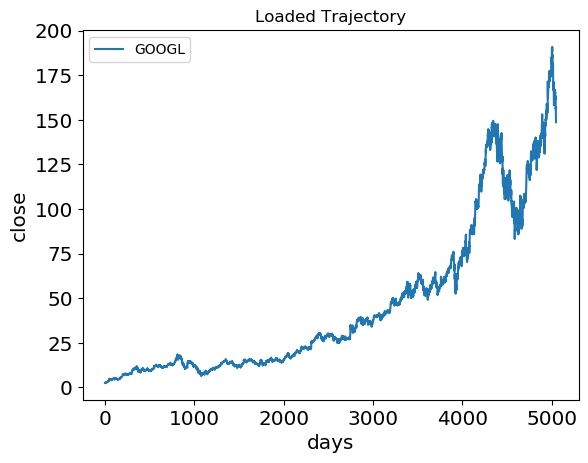

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
5043,2024-09-03 00:00:00-04:00,161.505697,161.635530,156.272635,157.151474,38945300,0.2,20.0
5044,2024-09-04 00:00:00-04:00,156.452404,158.789300,155.753335,156.242676,19353800,0.2,20.0
5045,2024-09-05 00:00:00-04:00,156.092875,159.238694,155.773291,157.031631,18688700,0.2,20.0
5046,2024-09-06 00:00:00-04:00,157.091551,157.620848,150.350496,150.720001,37912100,0.2,20.0
5047,2024-09-09 00:00:00-04:00,152.509995,153.399994,147.220001,148.710007,39221600,0.2,20.0


In [2]:
trj = loaddata_yahoo(symbol = 'GOOGL', interval = 'daily', start_date = '1990-01-01', verbose_plot = True)
#trj['Date'] = pd.to_datetime(trj['Date'])
trj.tail()

### Extracting memory kernel from trajectory using the generalized Langevin equation (GLE)
First we check for trend

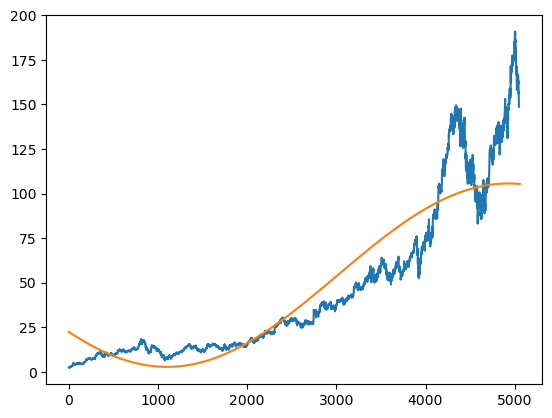

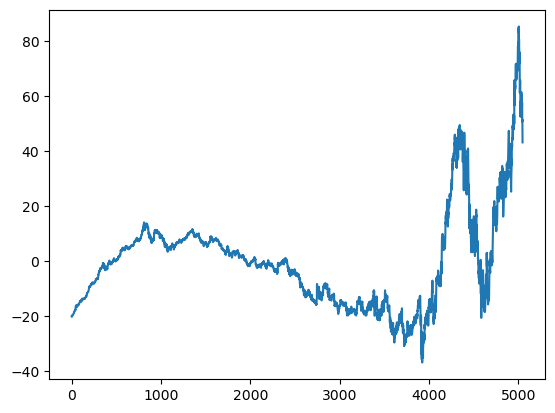

In [3]:
n_steps=10 #steps to predict
cut=len(trj)
t= trj.index.values
x = trj['Close'].values

#param,x_noise, x_trend = extrapolate_fourier_analysis_trend(trj.index,trj['Close'],cut,n_steps=n_steps,find_peaks=False,mph=0.01,N=1,verbose=True,fit=True)
#x_noise=x_noise.values

detrend = True
fit_trend_part = True
N_trend=2
deseasonalize = False
N_seas=5
fit_seas_part = False

x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                               N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part,fac_high=1000)



plt.plot(trj["Close"])
plt.plot(x_trend)
plt.show()

t_noise = np.arange(len(x_noise))
plt.plot(t_noise,x_noise)
plt.show()



plotting extracted memory kernel...


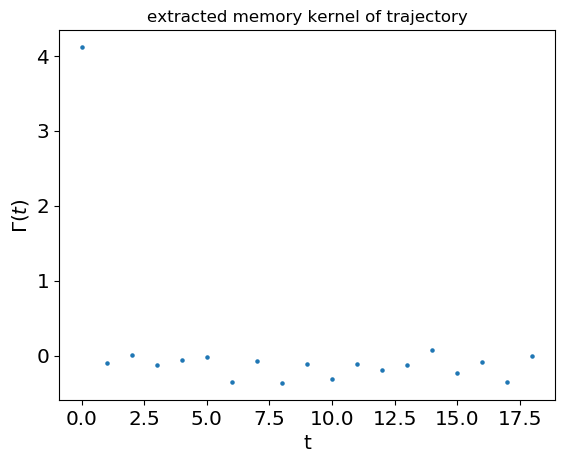

plotting running integral of kernel...


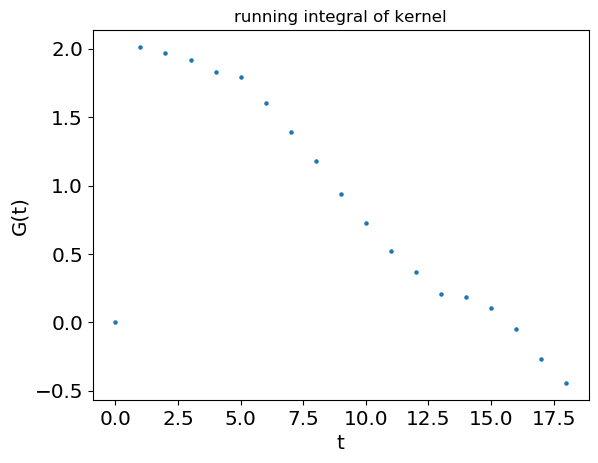

In [4]:
DEM = False #Discrete Estimation method, otherwise Volterra method is used

predict=GLEPrediction(bins=10,  cut = len(trj) ,trunc=20, dt = 1, no_fe=True, plot_pred = True)

if DEM:
    p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
    bounds = [[-10,0,0,0,0],[10,10,10,10,100]]
    kernel = predict.extractKernel_estimator([trj["Close"].values], plot_kernel =True,p0=p0,bounds=bounds,end=20,verbose=True)
else:
    kernel = predict.extractKernel([trj["Close"].values], fit_kernel = False,plot_kernel=True)


### Running a GLE-prediction with colored noise generation
Running multiple predictions and calculating the average

plotting prediction...


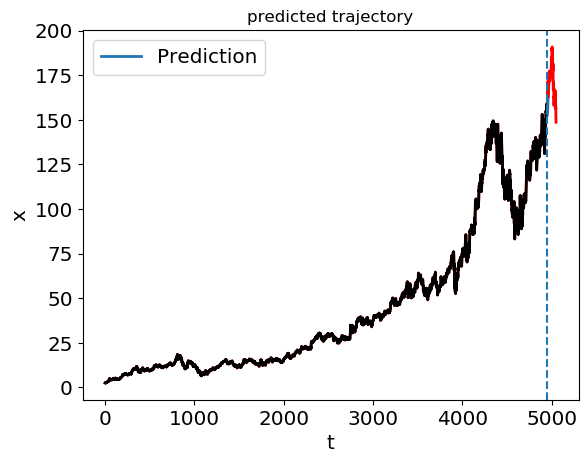

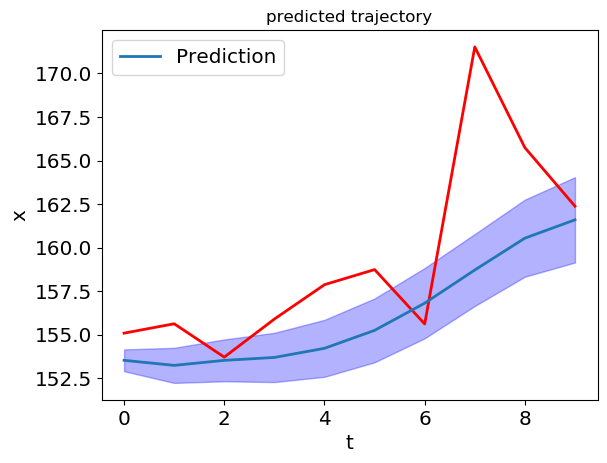

In [5]:
DEM = False

predict=GLEPrediction(bins=10,  cut = len(trj)-100 ,trunc=100, dt = 1, no_fe=True, plot_pred = True)

if DEM:
    p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
    bounds = [[-10,0,0,0,0],[10,10,10,10,100]]
    kernel = predict.extractKernel_estimator([trj["Close"].values], plot_kernel =True,p0=p0,bounds=bounds,end=20,verbose=True)
else:
    kernel = predict.extractKernel([trj["Close"].values], fit_kernel = False)

predGLE=predict.predictGLE([trj["Close"].values], n_steps=n_steps, n_preds = 100, return_full_trjs=True, zero_noise = False,cond_noise = 1)

### Running a Prediction with memoryless Langevin (non-linear potential)

plotting prediction...


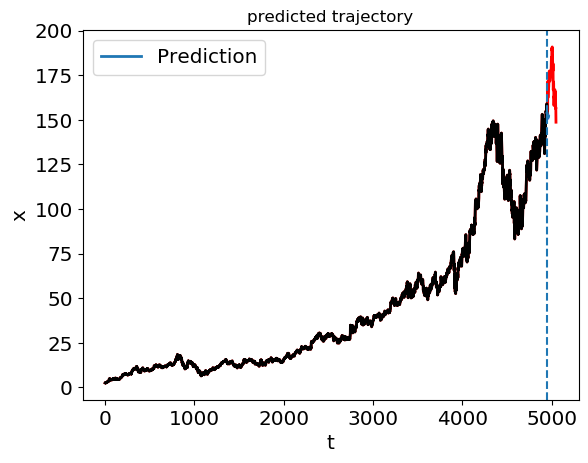

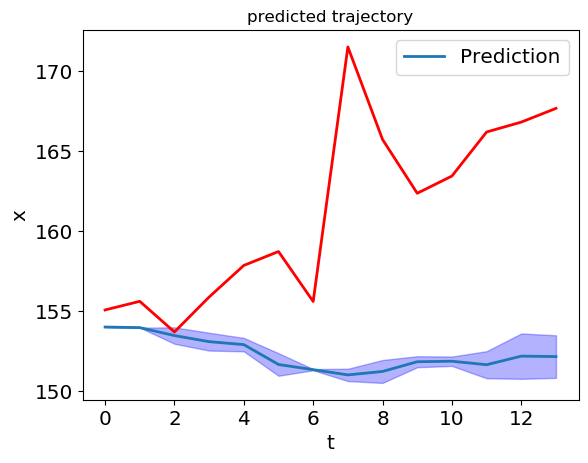

In [6]:
predict=GLEPrediction(bins=10,  cut = len(trj)-100 ,trunc=100, dt = 1, last_value_correction=True, no_fe=False, plot_pred = True)
predict.extractKernel([trj["Close"].values])
predGLE=predict.predictGLE([trj["Close"].values], n_steps=14, n_preds = 2, return_full_trjs=True, zero_noise = False, Langevin = True)

### GridSearch
find optimal values for hyper parameters in prediction (memory kernel length trunc, random force strength,...)
Attention: Only works for cut smaller than trajectory length

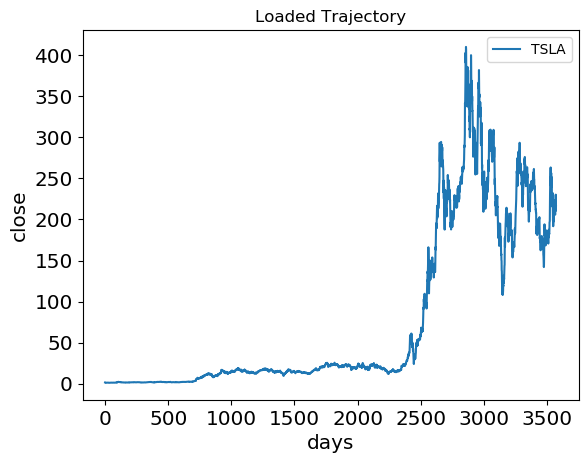

optimal alpha : 1
optimal trunc : 10
optimal conditional time : 10


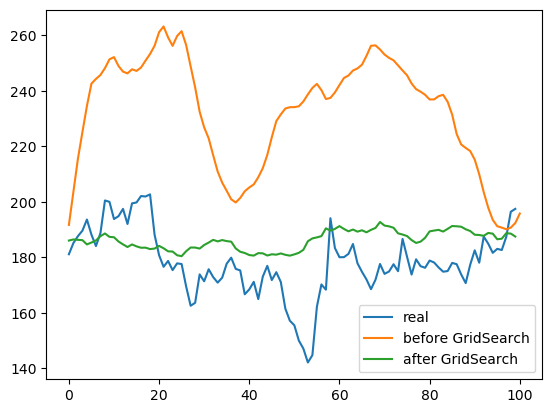

In [9]:
truncs = np.arange(10,100,25)
alphas = np.arange(1,400,20)
ts = [2,10]


trj = loaddata_yahoo(symbol = 'TSLA', interval = 'daily', start_date = '1990-01-01', verbose_plot = True)
cut = len(trj)-150
best_error, pred_GLE_best, best_trunc, best_alpha,best_th = mp.mp_grid_search(trj, value = 'Close', cut = cut, n_steps = 100, truncs = truncs, alphas = alphas,ts = ts)

mem = GLEPrediction(cut = cut, dt = 1, trunc = 100, plot_pred = False, no_fe = True)

kernel = mem.extractKernel([trj['Close'].values])
predGLE_default=mem.predictGLE([trj['Close'].values], n_steps = 100+1, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise=1)

plt.plot(trj['Close'][cut:cut+100].values, label = 'real')
plt.plot(predGLE_default[2], label = 'before GridSearch')
plt.plot(pred_GLE_best, label = 'after GridSearch')
plt.legend(loc = 'best')


### Running a prediction with GBM (linear drift) (not fixed)

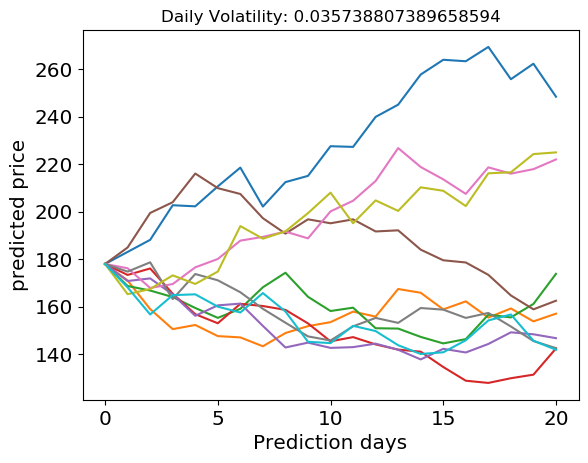

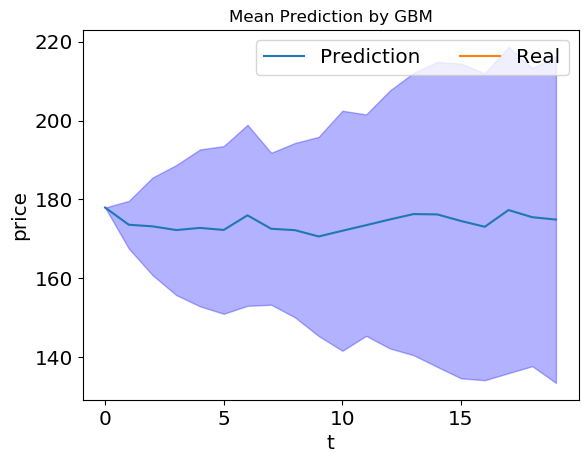

In [8]:
dt = 1
cut=len(trj)-1
n_steps=20
scen_size = 10

GBM = predictGBM(trj, value = 'Close', cut = cut, dt = 1, n_steps = n_steps, scen_size = scen_size, plot_pred = True)

